In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import datasets
%matplotlib inline

In [2]:
df = pd.read_csv('C:/Users/mauri/Desktop/regression_data_2.csv')

# Lets explore the data, check each columns, and do basic standarization

In [3]:
df.head(0)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price


In [4]:
df.shape

(21597, 21)

In [5]:
df.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [7]:
# I decided to find out how old the the property is, so i made and inserted a new column for that purpose
recent_year = 2015
age = recent_year - df['yr_built']
age = pd.DataFrame(age)
# Insert into Dataframe
df.insert(13,'age',age)

In [8]:
#Turning date into datetime format
df['date']= pd.to_datetime(df['date'])

In [9]:
# Lets keep track of our columns lost
rows_before_drop = df.shape[0]

In [10]:
# Check for ID Duplicates, as there are some rows that have duplicate ID's, but not necessarily fully duplicated rows
df.duplicated(subset = ['id'] ).sum()

177

In [11]:
# Drop duplicates
df.drop_duplicates(subset = ['id'], inplace = True)

In [12]:
# How many rows we lost from drop
print('We lost a total of',rows_before_drop-df.shape[0], 'rows after the drop, or', 177/rows_before_drop*100, 'percent of our data')

We lost a total of 177 rows after the drop, or 0.8195582719822199 percent of our data


In [13]:
# Reset Index
df.reset_index(drop=True, inplace = True)

## Above code was to clean the duplicate id columns, from here, i am gonna to modify the data a bit
## I will first extract the month and the year from date, this will reduce my unique dates from 372 to around 13! much better :o

In [14]:
print('We have a total of',df['date'].nunique(),'unique dates in our "date" column')

We have a total of 372 unique dates in our "date" column


In [15]:
#Used this to extract the year and month from date
df['date'] = df['date'].dt.strftime('%Y-%m')
#Cast to Datetime Again
df['date']= pd.to_datetime(df['date'])

In [16]:
print('Total amount of unique values in date:',df['date'].nunique())

Total amount of unique values in date: 13


# Data to be dropped
### We will drop waterfront for sure
### I also will take the liberty 
### We will also drop ID, as it doesn't influence our model, its a 'placeholder'

In [17]:
print('The data in waterfront is overrepresented by one value, that value taking up',(df['waterfront'].value_counts()/df.shape[0]*100).values[0],'% of the data')
print('The data in view is overrepresented by one value, that value taking up',(df['view'].value_counts()/df.shape[0]*100).values[0],'% of the data')
print('The data in yr_renovated is overrepresented by one value, that value taking up',(df['yr_renovated'].value_counts()/df.shape[0]*100).values[0],'% of the data')

The data in waterfront is overrepresented by one value, that value taking up 99.2390289449113 % of the data
The data in view is overrepresented by one value, that value taking up 90.13071895424837 % of the data
The data in yr_renovated is overrepresented by one value, that value taking up 95.75163398692811 % of the data


In [18]:
df.drop(['waterfront','view','yr_renovated','id','yr_built','zipcode'], axis = 1, inplace = True)

In [19]:
#Taking date sold and repurposing it into days sold
date1 = dt.datetime(2015,5,1,0,0,0)

# date1 = date1.strftime('%Y-%m-%d') # Not needed but still helpful

type(date1)

df['date'].max()

time_past = date1 - df['date']

time_past = time_past.dt.days #extracts days from timedelta

df['date'] = time_past

df.rename(columns = {'date':'days_sold'}, inplace = True)

# Check for Null Values: None
# Saving a row count to keep track of rows before drop

In [20]:
df.isna().sum()

days_sold        0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
condition        0
grade            0
sqft_above       0
sqft_basement    0
age              0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

In [21]:
df.dtypes

days_sold          int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
age                int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

In [22]:
rows_before_drop = df.shape[0]

In [23]:
rows_before_drop

21420

# Exploratory Data Analysis
# 1. The following will have some IQR, upper and low calculations, to assist in the outlier removal process

In [24]:
rc_intial = df.shape[0]
rc_intial

21420

In [25]:
df_stats = df.loc[:, ~df.columns.isin(['zipcode','grade','condition','bedrooms'])].describe().T.round(8)

In [26]:
df_stats['IQR'] = df_stats['75%'] - df_stats['25%']

In [27]:
df_stats['lower_limit'] = df_stats['25%'] - 1.5*df_stats['IQR']
df_stats['upper_limit'] = df_stats['75%'] + 1.5*df_stats['IQR']

In [28]:
df_stats.round(2)

,count,mean,std,min,25%,50%,75%,max,IQR,lower_limit,upper_limit
days_sold,21420.0,199.47,113.08,0.00,89.00,212.00,304.00,365.00,215.00,-233.50,626.50
bathrooms,21420.0,2.12,0.77,0.50,1.75,2.25,2.50,8.00,0.75,0.62,3.62
sqft_living,21420.0,2083.13,918.81,370.00,1430.00,1920.00,2550.00,13540.00,1120.00,-250.00,4230.00
sqft_lot,21420.0,15128.04,41530.80,520.00,5040.00,7614.00,10690.50,1651359.00,5650.50,-3435.75,19166.25
floors,21420.0,1.50,0.54,1.00,1.00,1.50,2.00,3.50,1.00,-0.50,3.50
sqft_above,21420.0,1791.17,828.69,370.00,1200.00,1560.00,2220.00,9410.00,1020.00,-330.00,3750.00
sqft_basement,21420.0,291.96,442.88,0.00,0.00,0.00,560.00,4820.00,560.00,-840.00,1400.00
age,21420.0,43.91,29.39,0.00,18.00,40.00,63.00,115.00,45.00,-49.50,130.50
lat,21420.0,47.56,0.14,47.16,47.47,47.57,47.68,47.78,0.21,47.16,47.99
long,21420.0,-122.21,0.14,-122.52,-122.33,-122.23,-122.12,-121.32,0.20,-122.63,-121.82


# 2. We also have a heatmap, which can give us a quick check for colinearity

In [29]:
corr_matrix = df.corr()
corr_matrix

,days_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,age,lat,long,sqft_living15,sqft_lot15,price
days_sold,1.000000,0.015260,0.030254,0.030194,-0.006912,0.018110,0.049353,0.034006,0.023944,0.017840,0.004010,0.030427,0.005149,0.027653,-0.003406,0.001531
bedrooms,0.015260,1.000000,0.515383,0.579069,0.032490,0.177734,0.025893,0.357988,0.480242,0.302748,-0.155241,-0.011266,0.132439,0.394949,0.030570,0.309453
bathrooms,0.030254,0.515383,1.000000,0.755522,0.087779,0.501803,-0.129362,0.665587,0.686328,0.283205,-0.506252,0.023143,0.223808,0.569453,0.087760,0.526229
sqft_living,0.030194,0.579069,0.755522,1.000000,0.172586,0.352868,-0.061677,0.762477,0.876533,0.434505,-0.316646,0.050739,0.240212,0.756186,0.183837,0.701875
sqft_lot,-0.006912,0.032490,0.087779,0.172586,1.000000,-0.005561,-0.009169,0.113656,0.183210,0.015239,-0.052312,-0.085822,0.230265,0.143805,0.717743,0.089111
floors,0.018110,0.177734,0.501803,0.352868,-0.005561,1.000000,-0.266859,0.458091,0.522751,-0.246078,-0.488935,0.048900,0.124812,0.279071,-0.011367,0.256286
condition,0.049353,0.025893,-0.129362,-0.061677,-0.009169,-0.266859,1.000000,-0.150508,-0.161483,0.174204,0.365129,-0.015566,-0.107154,-0.095256,-0.003450,0.034779
grade,0.034006,0.357988,0.665587,0.762477,0.113656,0.458091,-0.150508,1.000000,0.756221,0.166854,-0.446235,0.112815,0.198555,0.713178,0.120056,0.668020
sqft_above,0.023944,0.480242,0.686328,0.876533,0.183210,0.522751,-0.161483,0.756221,1.000000,-0.052672,-0.422977,-0.002040,0.344161,0.731887,0.194445,0.605294
sqft_basement,0.017840,0.302748,0.283205,0.434505,0.015239,-0.246078,0.174204,0.166854,-0.052672,1.000000,0.134532,0.109081,-0.145628,0.199334,0.017558,0.323536


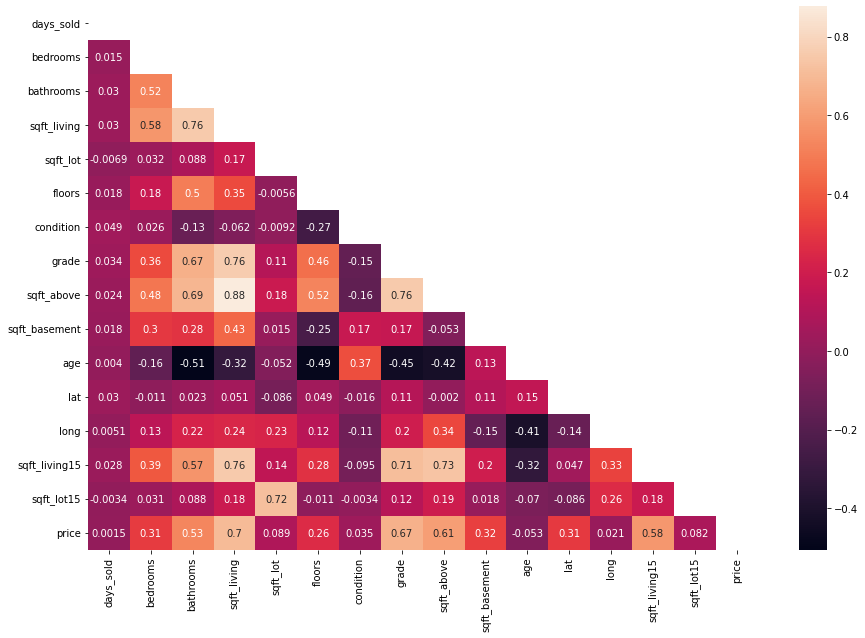

In [30]:
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(data = corr_matrix,mask=mask ,annot=True)

# 3. We will not draw some distribution plots to take a general look at our data
## NOTE: Some of the data plotted is categorical in nature, thus isn't well represented with distribtion plots
## It is still helpful to see them this way, to see which ones are categorical in nature.

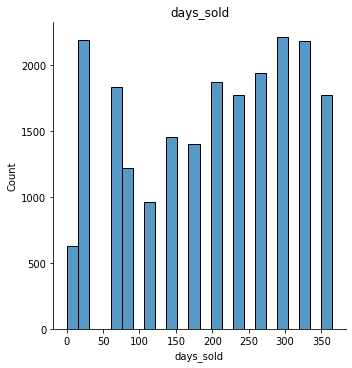

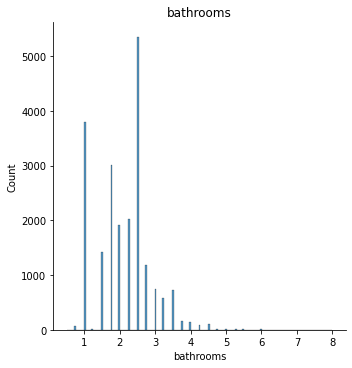

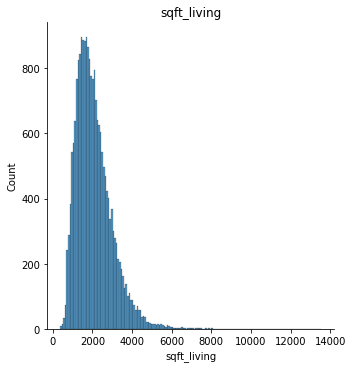

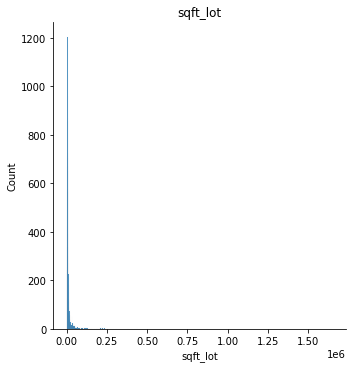

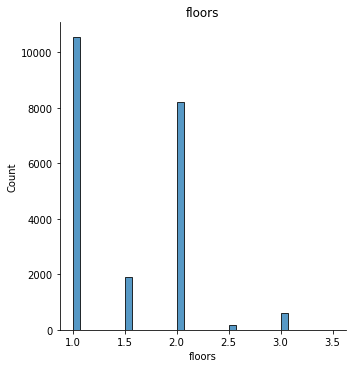

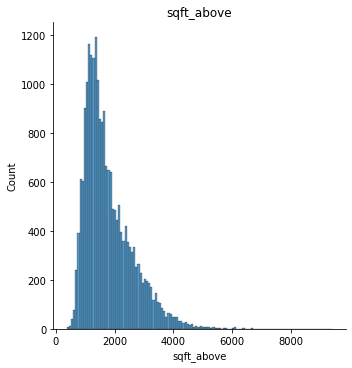

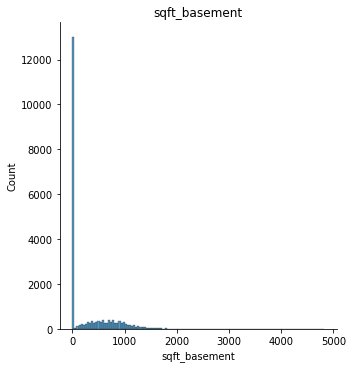

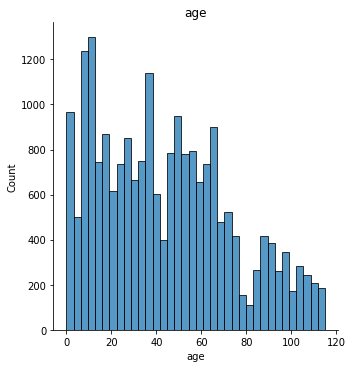

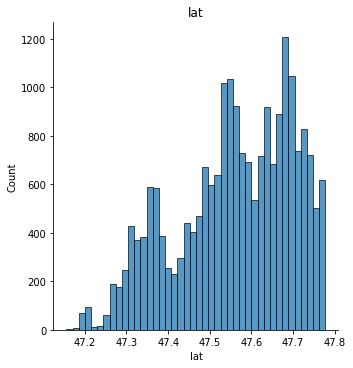

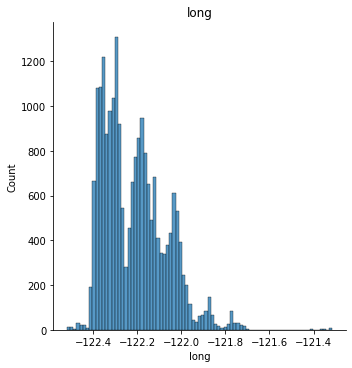

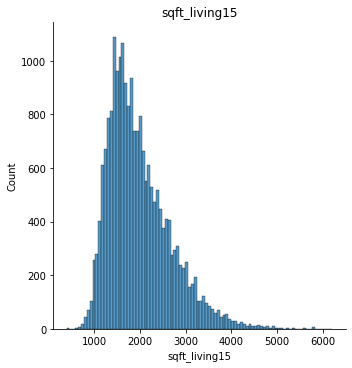

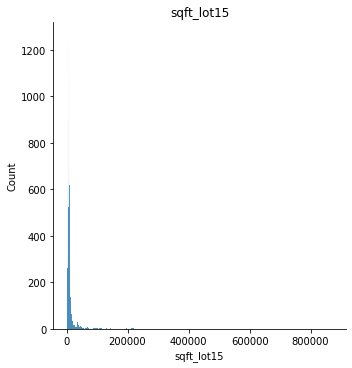

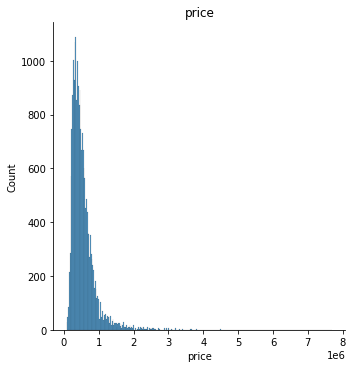

In [31]:
df_stats_col = list(df_stats.index)
for i in df_stats_col:
    plt.figure
    sns.displot(df[i])
    plt.title(i)
    plt.show()

In [32]:
df['sqft_lot'].value_counts()/df.shape[0]*100

5000      1.657330
6000      1.335201
4000      1.162465
7200      1.017740
7500      0.550887
            ...   
24330     0.004669
215622    0.004669
6022      0.004669
2323      0.004669
1076      0.004669
Name: sqft_lot, Length: 9776, dtype: float64

# 4. Using Countplot to count our catgegoical data is a bit more useful
## The following two graphs are a count of bathrooms and floors, respecfully.

In [33]:
df_bar1 = df[['bathrooms','price']].groupby(['bathrooms']).mean().round(3) #Getting Average price of bathroom per bathroom type, same for the following features

df_bar2 = df[['floors','price']].groupby(['floors']).mean().round(3)

df_bar3 = df[['condition','price']].groupby(['condition']).mean().round(3)

df_bar4 = df[['grade','price']].groupby(['grade']).mean().round(3)

df_bar5 = df[['days_sold','price']].groupby(['days_sold']).mean().round(3)

df_bar6 = df[['bedrooms','price']].groupby(['bedrooms']).mean().round(3)


df_bar1.reset_index(inplace = True) #Reset the index so we can graph it

df_bar2.reset_index(inplace = True)

df_bar3.reset_index(inplace = True)

df_bar4.reset_index(inplace = True)

df_bar5.reset_index(inplace = True)

df_bar6.reset_index(inplace = True)


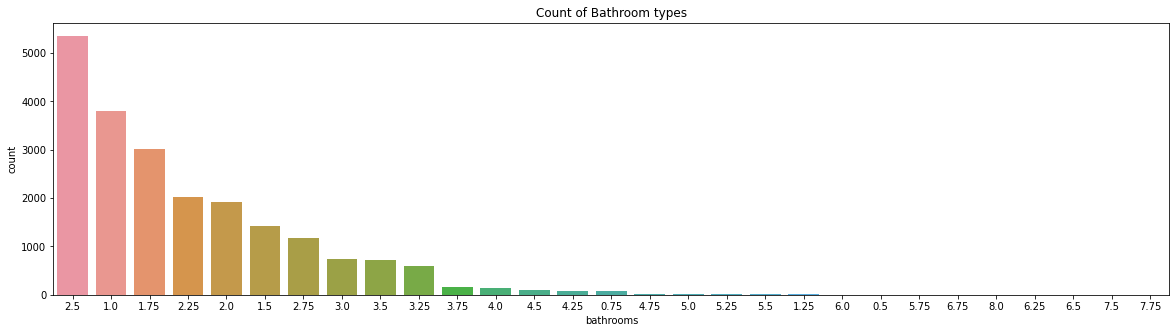

In [34]:
order_bathroom = df['bathrooms'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.countplot(x = df['bathrooms'], order = order_bathroom)
plt.title('Count of Bathroom types')
plt.show()

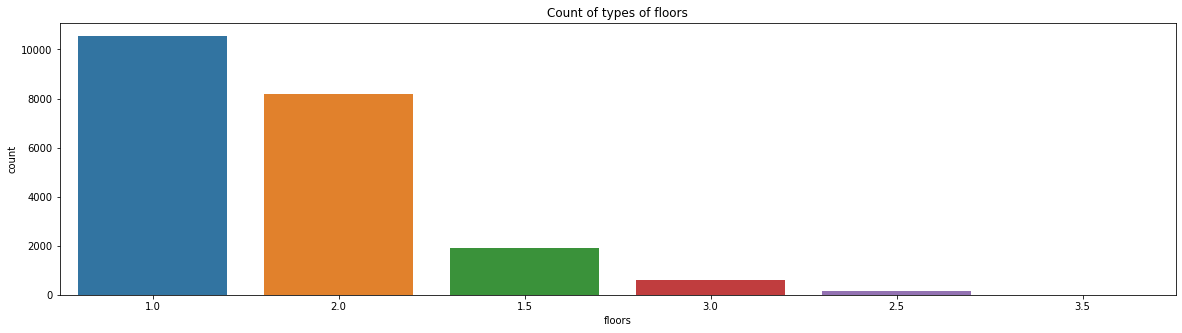

In [35]:
order_bathroom = df['floors'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.countplot(x = df['floors'], order = order_bathroom)
plt.title('Count of types of floors')
plt.show()

# 

# 5. The following code is an a categorical feature vs average price for each.
## Following each code, we removed small representations of our data, i.e if a value pops up 6 times out of around 20,00 rows, it is removed
## See first instance to understand logic throughout

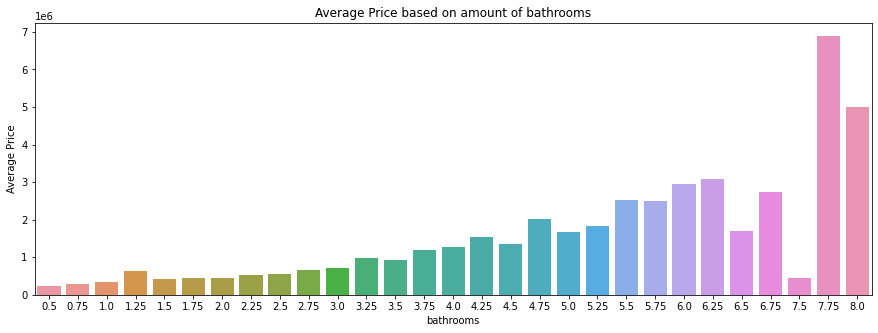

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x = 'bathrooms' , y = 'price' , data = df_bar1)
plt.ylabel('Average Price')
plt.title('Average Price based on amount of bathrooms')
plt.show()

In [37]:
bath_percent = df['bathrooms'].value_counts()/df.shape[0]*100 # Check to see percentage represented by each value

bath_percent.values[0:14].sum() # A rudimentary way to check how much a certain amount of values take up the whole data set, i.e the first 13 values take up 99% of our data 

bathroom_filter = bath_percent.index[0:14].tolist() # Take those values that take up 95%-99% of our data 

rows_before_bathroom_filter = df.shape[0] # Row check before

df = df[df['bathrooms'].isin(bathroom_filter)] #Keep only those values which our in our 95 to 99% percent

rows_after_bathroom_filter = df.shape[0] # Row check after

r_filter_bathroom = rows_before_bathroom_filter - rows_after_bathroom_filter # How many rows did we lose?

In [38]:
print('We lost',r_filter_bathroom,'rows')

We lost 170 rows


## Because we will use bathrooms as a categorical column, we will bin the number of values. 
## This will reduce the amount of columns created using OneHotEncoding
## For this specific case, using apply with math.trunc will work pretty well instead of a hand-made function, as for example, it will consider 4.25 bathrooms and 4.75 bathooms as the same
## which is what I desire in this case

In [39]:
df['bathrooms'] = df['bathrooms'].apply(math.trunc)

In [40]:
df['bathrooms'].value_counts()

2    10478
1     8243
3     2217
4      312
Name: bathrooms, dtype: int64

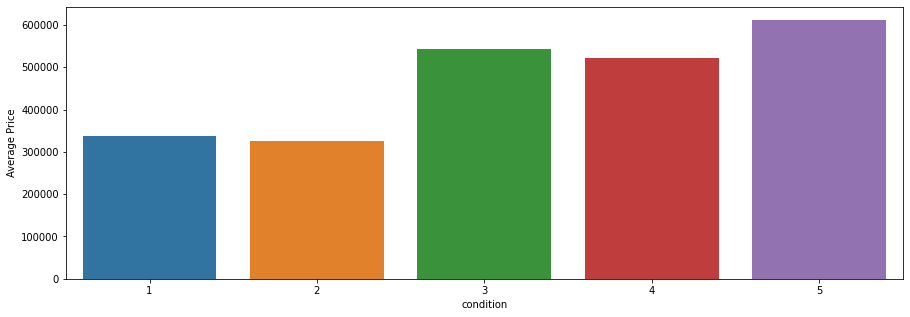

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x = 'condition' , y = 'price' , data = df_bar3)
plt.ylabel('Average Price')
plt.show()

In [42]:
condition_percent = df['condition'].value_counts()/df.shape[0]*100

condition_percent.values[0:3].sum()

condition_percent_list = condition_percent.index[0:3].tolist()

before_condition_filter = df.shape[0]

df = df[df['condition'].isin(condition_percent_list)]

after_condition_filter = df.shape[0]

r_filter_condition = before_condition_filter - after_condition_filter

In [43]:
print('We lost',r_filter_condition,'rows')

We lost 184 rows


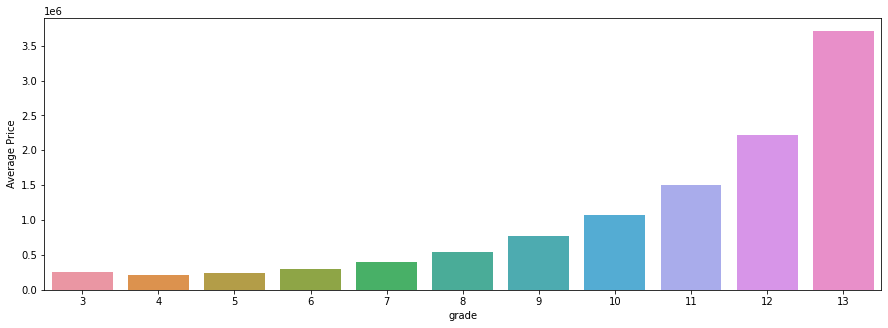

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x = 'grade' , y = 'price' , data = df_bar4)
plt.ylabel('Average Price')
plt.show()

In [45]:
grade_percent = df['grade'].value_counts()/df.shape[0]*100
grade_percent.values[0:7].sum()
grade_list = grade_percent.index[0:7].tolist()
rows_before_grade_filter = df.shape[0]
df = df[df['grade'].isin(grade_list)]
rows_after_grade_filter = df.shape[0]
r_filter_grade = rows_before_grade_filter-rows_after_grade_filter

In [46]:
print('We lost',r_filter_grade,'rows')

We lost 85 rows


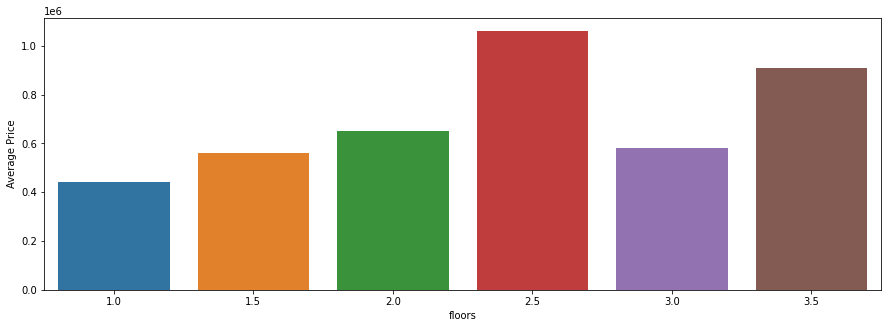

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x = 'floors' , y = 'price' , data = df_bar2)
plt.ylabel('Average Price')
plt.show()

In [48]:
floors_percent = df['floors'].value_counts()/df.shape[0]*100
floors_percent.values[0:5].sum()
floors_filter = floors_percent.index[0:5].tolist()
before_floors_filter = df.shape[0]
df = df[df['floors'].isin(floors_filter)]
after_floors_filter = df.shape[0]
r_floors_filter = before_floors_filter - after_floors_filter

In [49]:
print('We lost',r_floors_filter,'rows')

We lost 6 rows


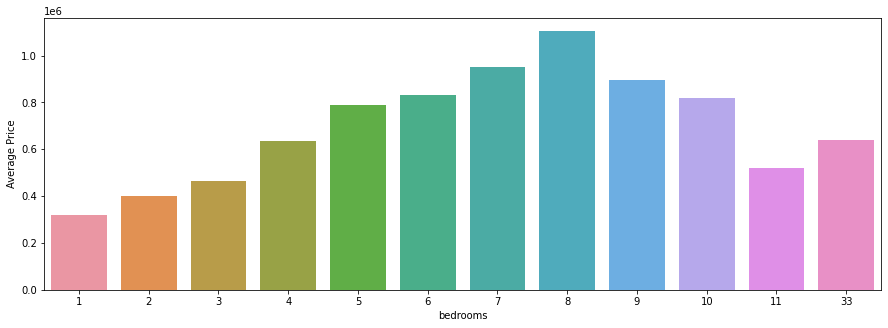

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x = 'bedrooms' , y = 'price' , data = df_bar6)
plt.ylabel('Average Price')
plt.show()

In [51]:
bedrooms_percent = df['bedrooms'].value_counts()/df.shape[0]*100
bedrooms_percent.values[0:7].sum()
bedroom_filter_list = bedrooms_percent.index[0:7]
before_bedroom_filter = df.shape[0]
df = df[df['bedrooms'].isin(bedroom_filter_list)]
after_bedroom_filter = df.shape[0]
r_filter_bedrooms = before_bedroom_filter -after_bedroom_filter

In [52]:
print('We lost',r_filter_bedrooms,'rows')

We lost 19 rows


### Because the Average price of a house does not seem to be affected by the days since it was sold, I elected to drop this column

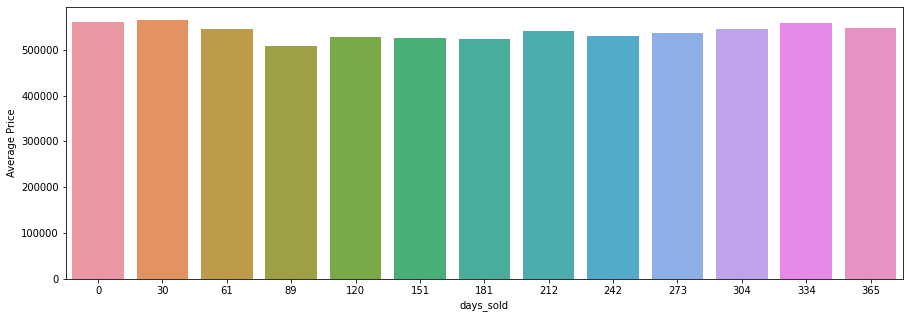

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.barplot(x = 'days_sold' , y = 'price' , data = df_bar5)
plt.ylabel('Average Price')
plt.show()
df.drop(['days_sold'],axis = 1, inplace = True)

# # Due to our low r2 score, one major thing we can do is change what we once considered numercal data, into categorical data.
### In the following code, we will cast some numerical columns which are in actuality, categorical in nature
### This step was the most difficult, it isn't always straight-foward
### A perfect example is bathrooms. Baring the fact they were binned, they were categorical in nature but they took on decimal values
### It could be arugued that they are discrete, specific, countable values, they are just countable in .25 blocks

In [54]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,age,lat,long,sqft_living15,sqft_lot15,price
0,3,1,1180,5650,1.0,3,7,1180,0,60,47.5112,-122.257,1340,5650,221900
1,3,2,2570,7242,2.0,3,7,2170,400,64,47.7210,-122.319,1690,7639,538000
2,2,1,770,10000,1.0,3,6,770,0,82,47.7379,-122.233,2720,8062,180000
3,4,3,1960,5000,1.0,5,7,1050,910,50,47.5208,-122.393,1360,5000,604000
4,3,2,1680,8080,1.0,3,8,1680,0,28,47.6168,-122.045,1800,7503,510000


In [55]:
list_to_cast = ['bedrooms','bathrooms','floors','condition','grade'] # Casting these to cateogricals
for c in list_to_cast:
    df[c] = df[c].apply(str)

In [56]:
df.dtypes # Did the previous code work?

bedrooms          object
bathrooms         object
sqft_living        int64
sqft_lot           int64
floors            object
condition         object
grade             object
sqft_above         int64
sqft_basement      int64
age                int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

### Our continous numercal data is very good, very close to normal. 
### at the moment, we will perform a log transformation on most of our numerical columns
### Most of our data benefited from the transformation, except age, which we will see soon

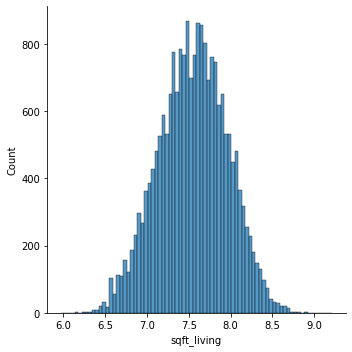

In [57]:
# log transformation for sqft_living works for postively skewed  data
def log_trans(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

df['sqft_living'] = df['sqft_living'].apply(log_trans)

avg_age = df['sqft_living'].mean() # Find avg of age column
df['sqft_living'] = df['sqft_living'].fillna(avg_age) # Replace nan values 

plt.figure
sns.displot(df['sqft_living']) # NOTE: Very close to a boxcox transformation at .33 or lower
plt.show()

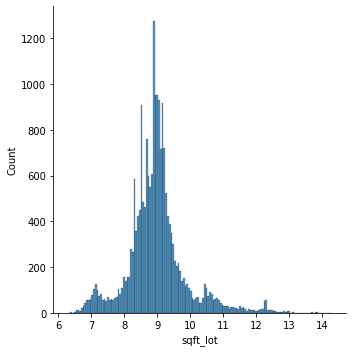

In [58]:
# log transformation for sqft_Lot works for postively skewed  data
def log_trans(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

df['sqft_lot'] = df['sqft_lot'].apply(log_trans)

avg_age = df['sqft_lot'].mean() # Find avg of age column
df['sqft_lot'] = df['sqft_lot'].fillna(avg_age) # Replace nan values 

plt.figure
sns.displot(df['sqft_lot']) # NOTE: Very close to a boxcox transformation at .33 or lower
plt.show()

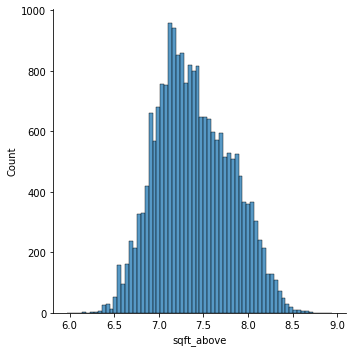

In [59]:
# log transformation for sqft_above
def log_trans(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

df['sqft_above'] = df['sqft_above'].apply(log_trans)

avg_age = df['sqft_above'].mean() # Find avg of age column
df['sqft_above'] = df['sqft_above'].fillna(avg_age) # Replace nan values 

plt.figure
sns.displot(df['sqft_above']) # NOTE: Very close to a boxcox transformation at .33 or lower
plt.show()

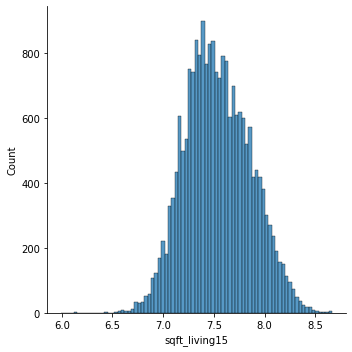

In [60]:
# log transformation for sqft_above
def log_trans(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

df['sqft_living15'] = df['sqft_living15'].apply(log_trans)

avg_age = df['sqft_living15'].mean() # Find avg of age column
df['sqft_living15'] = df['sqft_living15'].fillna(avg_age) # Replace nan values 

plt.figure
sns.displot(df['sqft_living15']) # NOTE: Very close to a boxcox transformation at .33 or lower
plt.show()

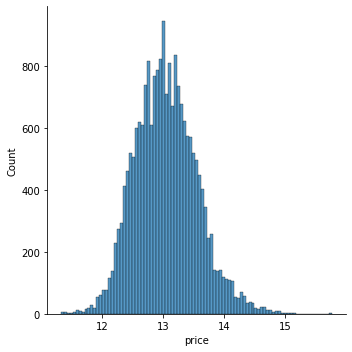

In [61]:
# log transformation for price
def log_trans(x):
    x = np.log(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

df['price'] = df['price'].apply(log_trans)

avg_age = df['price'].mean() # Find avg of age column
df['price'] = df['price'].fillna(avg_age) # Replace nan values 

plt.figure
sns.displot(df['price']) # NOTE: Very close to a boxcox transformation at .33 or lower
plt.show()

# Boxcox Transformation for age
## NOTE: I decided to perform a boxcox transformation, which required me to removed all zeros from my data, which in reality, removes houses built in the year 2015

In [62]:
print('Amount of rows with an age of zero, meaning they were built in the year 2015:',df[df['age'] == 0].shape[0])

Amount of rows with an age of zero, meaning they were built in the year 2015: 38


We lost this many rows after clearing out zeros for our boxcox transformation: 38
Current Size: 20918


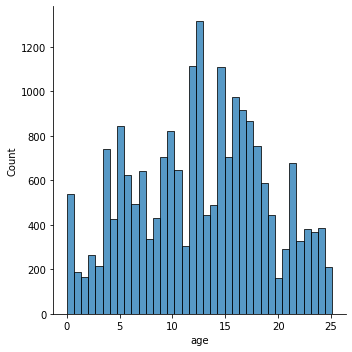

In [63]:
rows_before_boxcox = df.shape[0]

df = df[df['age'] != 0]  # Remove house with age of 0

rows_after_boxcox = df.shape[0] # Row check

bx_array = df['age'].to_numpy() # Turn our dataframe into a column

values, counts = np.unique(bx_array, return_counts = True) #unpack values and count of values

np.asarray([values, counts]).T #Pseudo value_counts() 

lmax_pearsonr = stats.boxcox_normmax(bx_array) #Optimum value for lambda in our boxcox transformation

test_cox = stats.boxcox(bx_array, lmbda = lmax_pearsonr) # Transformation

df['age'] = pd.Series(test_cox) #cast to series

df['age'].shape #Quick shape check

avg_age = df['age'].mean() # Find avg of age column
df['age'] = df['age'].fillna(avg_age) # Replace nan values 

# Rows lost and current size, along with a distribution of our new data. 
# Not perfect, but way better that what we saw above ✓
print('We lost this many rows after clearing out zeros for our boxcox transformation:', rows_before_boxcox-rows_after_boxcox)
print('Current Size:', rows_after_boxcox)
rows_lost_boxcox = rows_before_boxcox-rows_after_boxcox
plt.figure
sns.displot(df['age'])
plt.show()

# Boxplot analyis, as a general check to see what data needs outlier removal

In [64]:
box_list =df.loc[:, ~df.columns.isin(['zipcode','grade','condition','bedrooms', 'bathrooms', 'date', 'floors','age','lat'])].columns.tolist() #List of columns to make a boxplot of

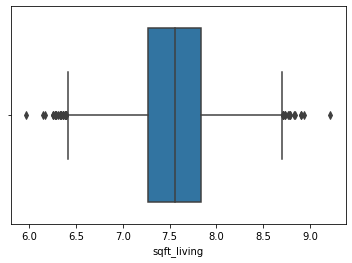

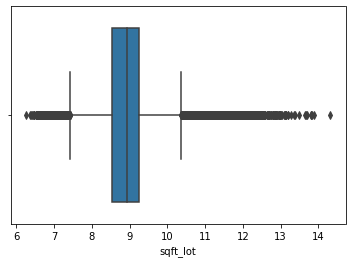

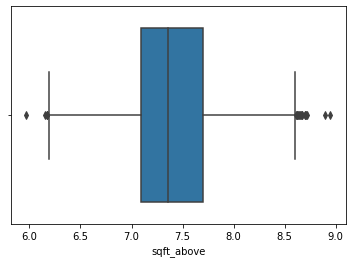

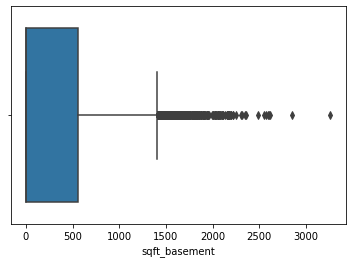

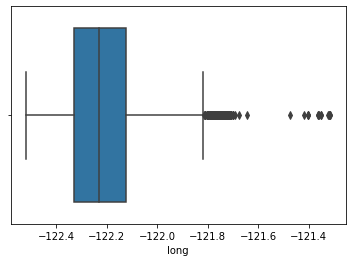

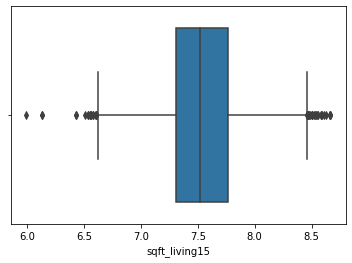

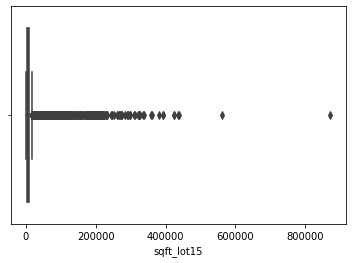

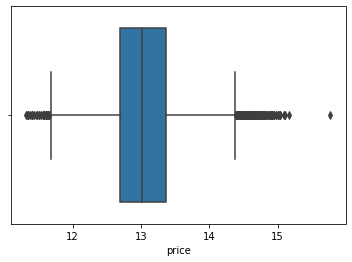

In [65]:
for i in box_list:
    plt.figure
    sns.boxplot(x = df[i])
    plt.show()

# Outlier Removal 
## The following Code is the general removal of outliers. 
## In general, i try not to remove more than 8% of my data
## I used a custom function to cut outliers, given a constant for upper and lower limits, and plots the graph
## Towards the end, we add up all lost rows to get a total count of all the rows we lost, duplicates not withstanding

In [66]:

total_lost = 0
def outlier(data, i, l = 1.5, u = 1.5):
    iqr = np.percentile(data[i], 75) - np.percentile(data[i], 25)
    lower_limit = np.percentile(data[i], 25) - l*iqr
    upper_limit = np.percentile(data[i], 75) + u*iqr
    data_chop = data[(data[i] > lower_limit) & (data[i] < upper_limit)]
    lost_rows = data.shape[0] - data_chop.shape[0]
    data = data_chop
    print(lost_rows)
    plt.figure
    sns.displot(data[i])
    plt.show
    return data, lost_rows

In [67]:
rows_before_outliers_removed = df.shape[0]

96


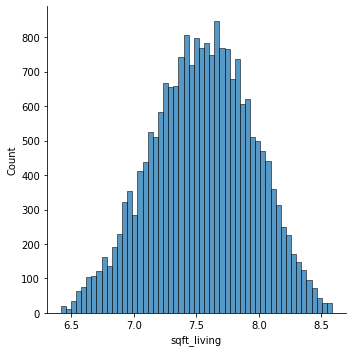

In [68]:
df, lost = outlier(df,'sqft_living', u = 1.3)

In [69]:
# df,lost_rows2 = outlier(df,'sqft_lot', u = 5) # Too many Rows lost, hold of for now

66


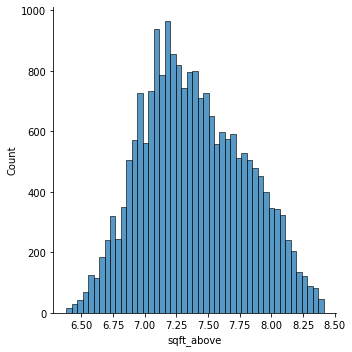

In [70]:
df, lost_3 = outlier(df,'sqft_above', l =1.2,u =1.2)

261


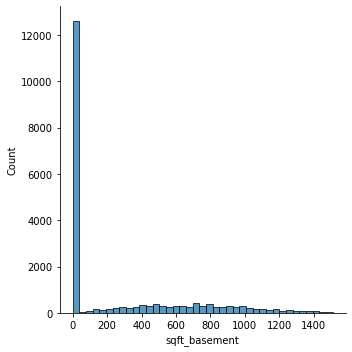

In [71]:
df , lost_4 =outlier(df,'sqft_basement', u =1.7)

240


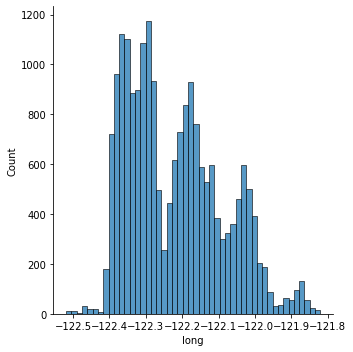

In [72]:
df, lost_5 = outlier(df,'long')

51


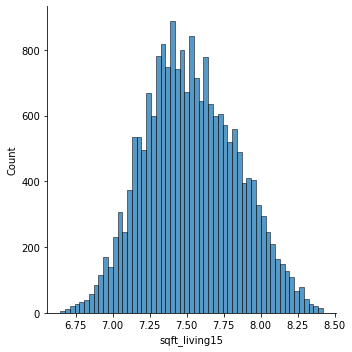

In [73]:
df, lost_6 = outlier(df,'sqft_living15')

In [74]:
# df, lost_7 = outlier(df,'sqft_lot15')

216


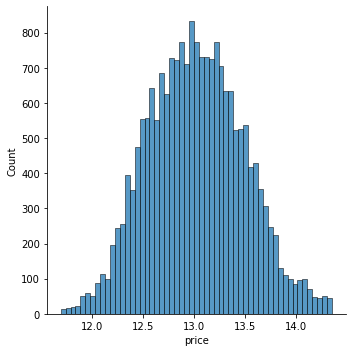

In [75]:
df, lost_8 = outlier(df,'price')

In [76]:
# Lets sum up the total amount of rows lost, to get a percentage of rows lost
rows_out_lost = lost+lost_3+lost_4+lost_5+lost_6+lost_8+r_filter_bathroom+r_filter_condition+r_filter_grade+r_filter_bedrooms+r_floors_filter+rows_lost_boxcox 

In [77]:
df.reset_index(inplace = True, drop = True) #Reset Index

In [78]:
print('We lost a total of', rows_out_lost, 'which is', round(rows_out_lost/rows_before_outliers_removed*100, 2) ,'% of our data')

We lost a total of 1432 which is 6.85 % of our data


In [79]:
df.shape[0] #Current Rows 

19988

# Normalizing our data
# First I separate my Target, then Cast my numerical and categorical columns to different dataframes to tranform them each one.

In [80]:
df.shape #Recheck of shape

(19988, 15)

In [81]:
# Removing the Target from the Column
Y = df['price']
df.drop(['price'], inplace = True, axis = 1)

In [82]:
df.shape

(19988, 14)

In [83]:
# Numerical Data 
X_num = df.select_dtypes(np.number) 

In [84]:
# Categorical Data
X_cat = df.select_dtypes(object)

In [85]:
#Function to choose and select which way we should transform our data
#This includes:

def transform_data(x_num_data, t = 'norm'):
    if t == 'norm':
        transformer = Normalizer().fit(X_num) #Normalizer
        x_trans = transformer.transform(X_num)
    elif t == 'stand':
        transformer = StandardScaler().fit(X_num) #Standard Scaler
        x_trans = transformer.transform(X_num)
    elif t == 'mm':
        transformer = MinMaxScaler().fit(X_num) #Min/Max Scaler
        x_trans = transformer.transform(X_num)   
    elif t == 'ma':
        transformer = MaxAbsScaler().fit(X_num) #Max Absolute Scaler
        x_trans = transformer.transform(X_num)
    else:
        pass
    return x_trans

# Linear Regression Model Choices
## Should you choose to see our linear model outcomes, run the following block of code
## Should you want to see the results of our K-Nearest Neighboor model, see next markdown block

# A for loop to return every r2, mse, mae, and adjusted_r2 score for each numercal transformation and graph
x_trans_1 = transform_data(X_num, t = 'norm')
x_trans_2 = transform_data(X_num, t = 'stand')
x_trans_3 = transform_data(X_num, t = 'mm')
x_trans_4 = transform_data(X_num, t = 'ma')

X_list = [x_trans_1,x_trans_2,x_trans_3,x_trans_4]
# OneHotEncode our Categorical Data
encoder = OneHotEncoder().fit(X_cat)
encoded = encoder.transform(X_cat).toarray()

# Turn our array into a dataframe
r2_info = []
mse_info = []
mae_info = []
adjr2_info = []
# A for loop to append a list of measures of error for each 
# BIG NOTE: The order in which each transformation was applied was the following
# Normalizer, StandardScaler, MinMaxScaler, and finally MaxAbsScaler
for i in X_list:
    X = np.concatenate((i,encoded), axis= 1)
    X.shape
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=.20,random_state=100)
    lm = LinearRegression().fit(x_train,y_train)
    predictions = lm.predict(x_test)
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    n = len(x_test) 
    p = x_test.shape[1]
    adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
    adj_r2 # Penalty for adj_r2
    
    r2_info.append(r2)
    mse_info.append(mse)
    mae_info.append(mae)
    adjr2_info.append(adj_r2)

# A Grouped Bar Graph to Compare the different measures of error.
w = 0.2
names = ['Normalizer','StandardScaler','Min/Max','MaxAbsolute']

bar1 = np.arange(len(names))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]

plt.figure(figsize = (16,8))

r2_container = plt.bar(bar1,r2_info,w,label = 'r2 score')
mse_container = plt.bar(bar2,mse_info,w,label = 'mse score')
mae_container = plt.bar(bar3,mae_info,w,label = 'mae score')
adjr2_container = plt.bar(bar4,adjr2_info,w,label = 'adj r2 score')

perfect_bar = [i+(w/2) for i in bar2]

plt.bar_label(r2_container)
plt.bar_label(mse_container)
plt.bar_label(mae_container)
plt.bar_label(adjr2_container)


plt.xlabel('Different Transformations')
plt.ylabel('Score Amount')
plt.title('Comparison of Different Transformations and Our Measures of Error')
plt.xticks(perfect_bar,names)
plt.legend()
plt.tight_layout()
plt.show()

# KNN Model, and we will use adjusted R-Squared as our measure of error
# Run the following block of code to see the outcomes of our K-Nearest Neighboors Model, from K values, 1 to 50

adjr2_norm
Max Score: 0.4966131600298642
For K Value: 33
adjr2_stand
Max Score: 0.7768733041123571
For K Value: 15
adjr2_mm
Max Score: 0.7208921935359539
For K Value: 7
adjr2_ma
Max Score: 0.49056643576251713
For K Value: 14


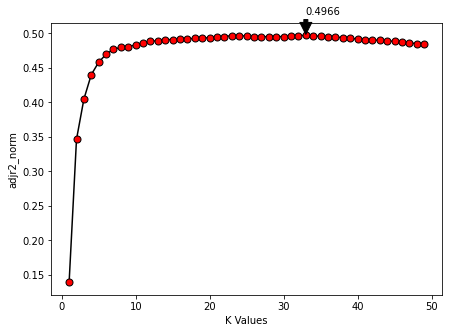

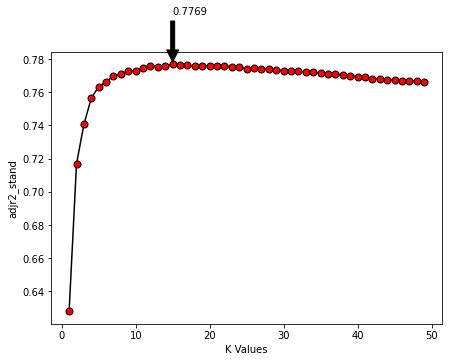

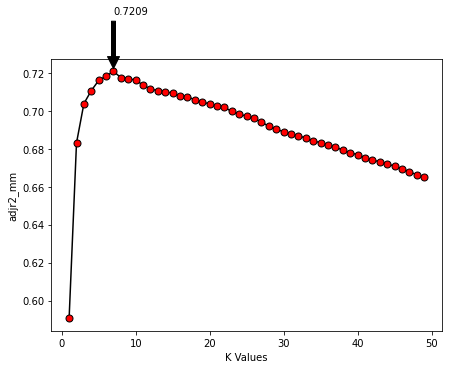

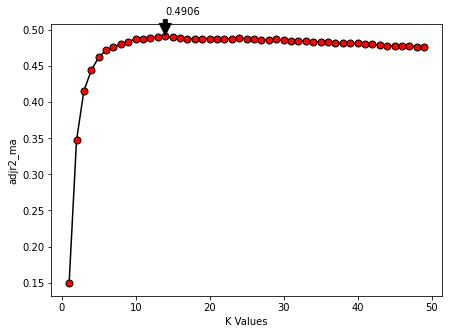

In [86]:
# Same as before, we will produce our arrays from our 4 different types of transformations
x_trans_1 = transform_data(X_num, t = 'norm')
x_trans_2 = transform_data(X_num, t = 'stand')
x_trans_3 = transform_data(X_num, t = 'mm')
x_trans_4 = transform_data(X_num, t = 'ma')

X_list = [x_trans_1,x_trans_2,x_trans_3,x_trans_4]
# OneHotEncode our Categorical Data
encoder = OneHotEncoder().fit(X_cat)
encoded = encoder.transform(X_cat).toarray()

#Next, we will create some empty lists to append later
adjr2_norm = []
adjr2_stand = []
adjr2_mm = []
adjr2_ma = []



testing = 50 #Modify this to test any amount of K-Values you want

k_values = [i for i in range(testing)] #List of nearest_neighboors values we want to predict
k_values.pop(0) #Popping zero, since we can't use it

# A for loop to append a list of measures of error for each 
for i in X_list:
    for j in k_values:
        current_array = i #Declaring the current array we are using for comparsion later
        X = np.concatenate((i,encoded), axis= 1)
        X.shape
        x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=.20,random_state=100) #Train test split
        km = KNeighborsRegressor(n_neighbors= j)
        km.fit(x_train, y_train) #training our model
        predictions = km.predict(x_test) #declare predictions
        r2 = r2_score(y_test, predictions)
        n = len(x_test) 
        p = x_test.shape[1]
        adj_r2 = 1-((1-r2)*(n-1)/(n-p-1)) # How to calculate adjusted R^2
        adj_r2 # Penalty for adj_r2
        
        # We compare the current array to the list of arrays we have. 
        # for example, if the currenty array matches the first array of our list, thats the signal to append the current list of adjusted R-squared values for each value of K, to each list
        # We will plot these points later
        
        if (current_array == X_list[0]).all() == True:
            adjr2_norm.append(adj_r2)
        elif (current_array == X_list[1]).all() == True:
            adjr2_stand.append(adj_r2)
        elif (current_array == X_list[2]).all() == True:
            adjr2_mm.append(adj_r2)
        elif (current_array == X_list[3]).all() == True:
            adjr2_ma.append(adj_r2)
        else:
            pass
        
        scores = [adjr2_norm, adjr2_stand, adjr2_mm,adjr2_ma] #List of lists of adjusted R-Squared values, 
        y_axis_labels = ['adjr2_norm', 'adjr2_stand', 'adjr2_mm','adjr2_ma'] #List of names for convenience
            
    

for i in range(4):
    #Find our Max X and Y coordinates
    y_max = max(scores[i])
    x_pos = scores[i].index(y_max)
    x_max = k_values[x_pos]
    x_max
    plt.figure(figsize = (7,5))
    plt.plot(k_values,scores[i], color = 'black', linestyle = 'solid', marker = 'o', markerfacecolor = 'red', markersize = 7)
    plt.xlabel('K Values')
    plt.ylabel(y_axis_labels[i])
    plt.annotate(round(y_max,4), xy=(x_max, y_max), xytext=(x_max, y_max+.03),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    plt.title(print(y_axis_labels[i]),
              print('Max Score:',y_max),
              print('For K Value:',x_max))

In [87]:
adjr2_stand

[0.6278042184202273,
 0.7168430859898522,
 0.7406585986217049,
 0.7565455388010283,
 0.7634569395466557,
 0.766302893631635,
 0.7700831810563464,
 0.7711483544913441,
 0.7726582785390899,
 0.7729586269007446,
 0.7747088041731562,
 0.7761372895665885,
 0.7755071782715718,
 0.7761346329849776,
 0.7768733041123571,
 0.7761844553909977,
 0.7762100576892659,
 0.7759139319851048,
 0.775844517935189,
 0.7757392202674185,
 0.7756404634432255,
 0.7757563227436711,
 0.7754906823662728,
 0.7751699182605807,
 0.7741836736153219,
 0.7745253536546872,
 0.7741401517135291,
 0.7738337134006626,
 0.7734010475192054,
 0.7731273108292677,
 0.772675752904529,
 0.7726227118157551,
 0.7723049303948051,
 0.7721380390243193,
 0.7714841542207711,
 0.7710216955612221,
 0.7709041490414389,
 0.770484303055732,
 0.7699572796392082,
 0.7694896582683155,
 0.7689992780979483,
 0.7682965215994549,
 0.7678328086374286,
 0.7675672327949012,
 0.7673443892749852,
 0.7666751677410371,
 0.7667524803112276,
 0.76670811639004

In [88]:
k_values

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]